# SET UP + Initial Analysis

OLD CODE (MUST RUN TO SETUP NOTEBOOK)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pywt
import pywt.data

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
subset_size = 10_000
indices = np.random.choice(len(trainset), subset_size, replace=False)
train_subset = Subset(trainset, indices)
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
images, labels = next(iter(trainloader))
print(f"Subset size: {len(train_subset)}")
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

100%|██████████| 170M/170M [00:02<00:00, 58.9MB/s]


Subset size: 10000
Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


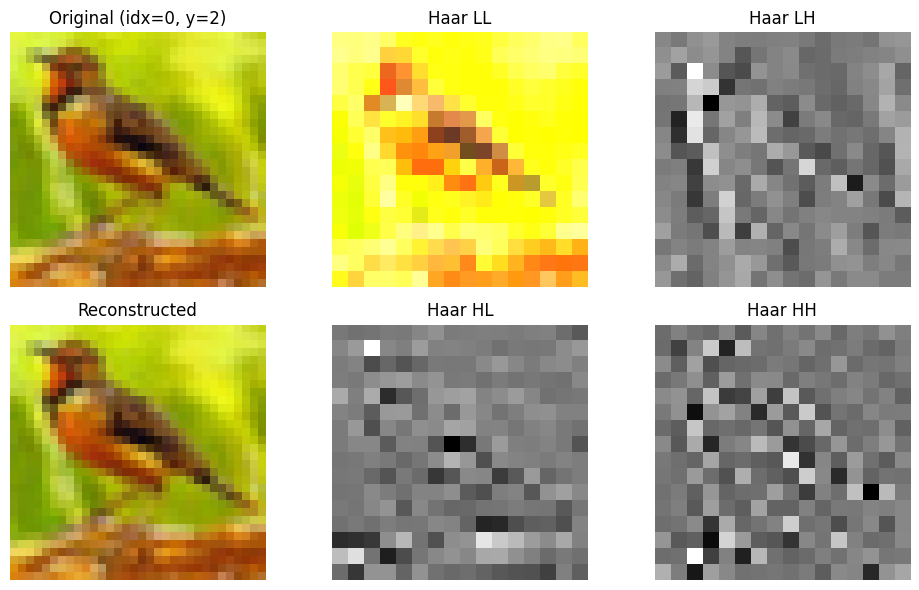

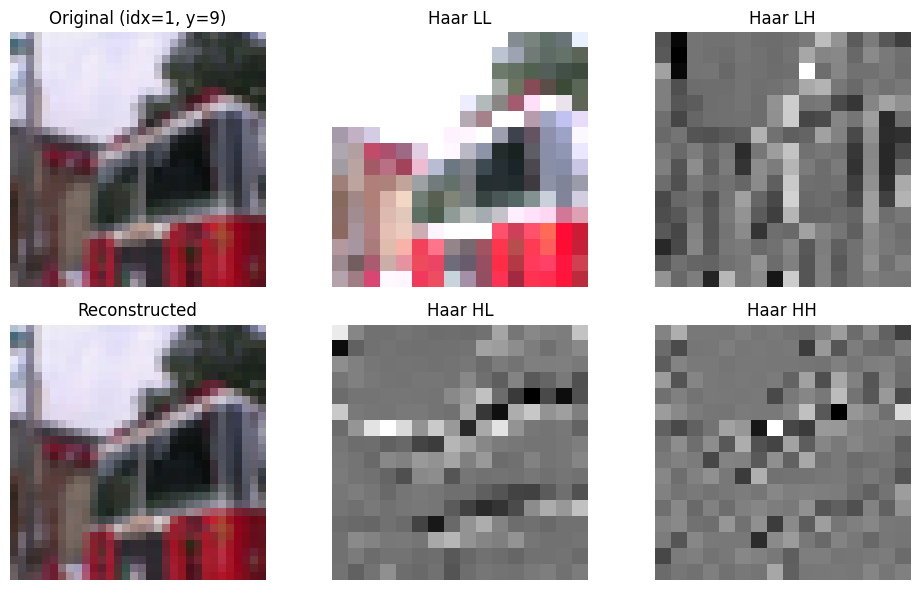

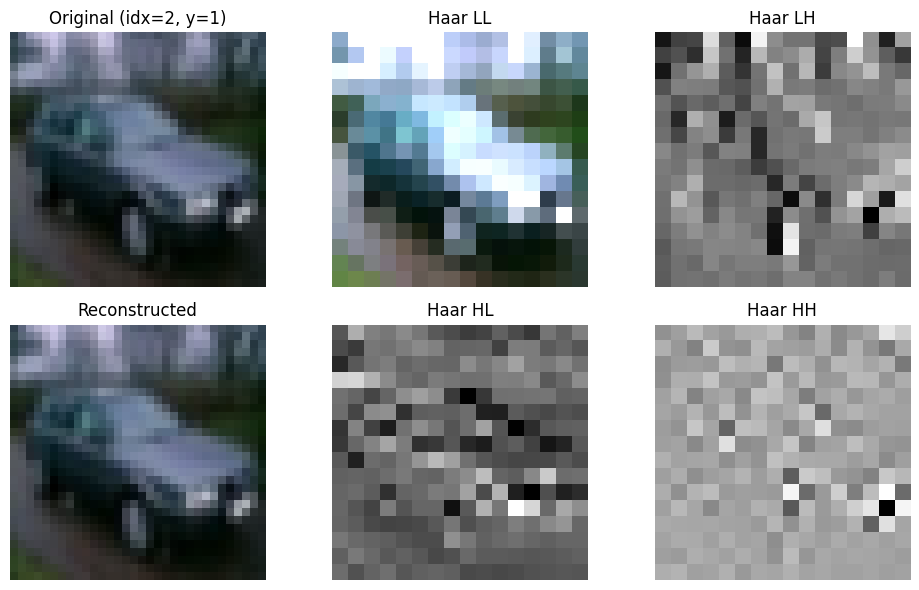

In [ ]:
# This cell loads 10,000 CIFAR-10 samples, applies a 1-level Haar DWT,
# reconstructs the image via inverse DWT, and visualizes a few examples
# in a 2x3 grid: (top) Original, LL, LH ; (bottom) Reconstructed, HL, HH.
#
# DB2 via PyWavelets is optional—set TRY_DB2 to True if pywt is installed.
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset

N_SAMPLES = 10_000
SAMPLE_INDICES = [0, 1, 2]  # which samples from the subset to visualize
TRY_DB2 = False             # set True to also try DB2 (requires pywt)

transform = transforms.ToTensor()  # keep in [0,1] for visualization
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
idxs = np.random.choice(len(train_full), N_SAMPLES, replace=False)
train = Subset(train_full, idxs)

def get_item(i):
    x, y = train[i]
    return x, y  # x: (3,32,32)

s = 1.0 / np.sqrt(2.0)

def haar_dwt2(img):
    """
    1-level separable Haar DWT.
    img: (C,H,W), H and W even.
    Returns: LL, LH, HL, HH each (C, H/2, W/2).
    """
    C, H, W = img.shape
    assert H % 2 == 0 and W % 2 == 0, "Image dims must be even."

    def down_cols(x):
        even = x[:, :, ::2]
        odd  = x[:, :, 1::2]
        low  = s * (even + odd)
        high = s * (even - odd)
        return low, high  # (C,H,W/2) each

    def down_rows(x):
        even = x[:, ::2, :]
        odd  = x[:, 1::2, :]
        low  = s * (even + odd)
        high = s * (even - odd)
        return low, high  # (C,H/2,W) each

    low_c, high_c = down_cols(img)
    LL, HL = down_rows(low_c)             # LL from low, HL from low-high (rows)
    LH, HH = down_rows(high_c)            # LH from high-low (rows), HH from high-high (rows)
    return LL, LH, HL, HH

def inv1d_upsample(low, high, dim):
    # permute so target dim is last
    if dim != -1:
        perm = list(range(low.dim()))
        perm[dim], perm[-1] = perm[-1], perm[dim]
        low  = low.permute(*perm)
        high = high.permute(*perm)

    even = (low + high) / np.sqrt(2.0)  # (..., N)
    odd  = (low - high) / np.sqrt(2.0)  # (..., N)

    N = even.shape[-1]
    out_shape = list(even.shape[:-1]) + [2 * N]
    out = even.new_zeros(out_shape)

    out[..., ::2] = even
    out[..., 1::2] = odd

    # permute back
    if dim != -1:
        inv_perm = list(range(out.dim()))
        inv_perm[dim], inv_perm[-1] = inv_perm[-1], inv_perm[dim]
        out = out.permute(*inv_perm)

    return out

def haar_idwt2(LL, LH, HL, HH):
    # First invert rows to get low_c and high_c (C,H,W/2)
    low_c  = inv1d_upsample(LL, HL, dim=1)
    high_c = inv1d_upsample(LH, HH, dim=1)

    # Then invert columns to get original (C,H,W)
    img = inv1d_upsample(low_c, high_c, dim=2)
    return img

# Optional DB2 via PyWavelets
def db2_dwt2(img):
    import pywt
    LLs, LHs, HLs, HHs = [], [], [], []
    for c in range(img.shape[0]):
        arr = img[c].cpu().numpy()
        LL, (LH, HL, HH) = pywt.dwt2(arr, "db2", mode="periodization")
        LLs.append(torch.from_numpy(LL))
        LHs.append(torch.from_numpy(LH))
        HLs.append(torch.from_numpy(HL))
        HHs.append(torch.from_numpy(HH))
    return torch.stack(LLs), torch.stack(LHs), torch.stack(HLs), torch.stack(HHs)

def db2_idwt2(LL, LH, HL, HH):
    import pywt
    chans = []
    for c in range(LL.shape[0]):
        rec = pywt.idwt2((LL[c].numpy(),
                          (LH[c].numpy(), HL[c].numpy(), HH[c].numpy())),
                         "db2", mode="periodization")
        chans.append(torch.from_numpy(rec))
    return torch.stack(chans)

def chw_to_hwc(img):
    x = img.detach().cpu()
    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).numpy()

def to_gray01(x):
    # average across channels, normalize to [0,1] for display
    g = x.mean(0)
    g = g - g.min()
    denom = g.max() - g.min()
    if denom > 1e-12:
        g = g / denom
    return g.numpy()

def plot_grid_original_wavelets_recon(img, LL, LH, HL, HH, recon, title_prefix="Haar", idx=0, label=None):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    axes[0,0].imshow(chw_to_hwc(img)); axes[0,0].set_title(f"Original (idx={idx}, y={label})"); axes[0,0].axis("off")

    LL_up = torch.nn.functional.interpolate(LL.unsqueeze(0), size=img.shape[1:], mode="nearest").squeeze(0)
    axes[0,1].imshow(chw_to_hwc(LL_up)); axes[0,1].set_title(f"{title_prefix} LL"); axes[0,1].axis("off")

    axes[0,2].imshow(to_gray01(LH), cmap="gray"); axes[0,2].set_title(f"{title_prefix} LH"); axes[0,2].axis("off")

    axes[1,0].imshow(chw_to_hwc(recon)); axes[1,0].set_title("Reconstructed"); axes[1,0].axis("off")
    axes[1,1].imshow(to_gray01(HL), cmap="gray"); axes[1,1].set_title(f"{title_prefix} HL"); axes[1,1].axis("off")
    axes[1,2].imshow(to_gray01(HH), cmap="gray"); axes[1,2].set_title(f"{title_prefix} HH"); axes[1,2].axis("off")

    plt.tight_layout()
    plt.show()

for i in SAMPLE_INDICES:
    img, y = get_item(i)  # (3,32,32)

    LL, LH, HL, HH = haar_dwt2(img)
    recon = haar_idwt2(LL, LH, HL, HH).clamp(0,1)

    plot_grid_original_wavelets_recon(img, LL, LH, HL, HH, recon, title_prefix="Haar", idx=i, label=y)

    if TRY_DB2:
        try:
            LL2, LH2, HL2, HH2 = db2_dwt2(img)
            recon2 = db2_idwt2(LL2, LH2, HL2, HH2).clamp(0,1)
            plot_grid_original_wavelets_recon(img, LL2, LH2, HL2, HH2, recon2, title_prefix="DB2", idx=i, label=y)
        except Exception as e:
            print("DB2 (pywt) not available or failed:", e)


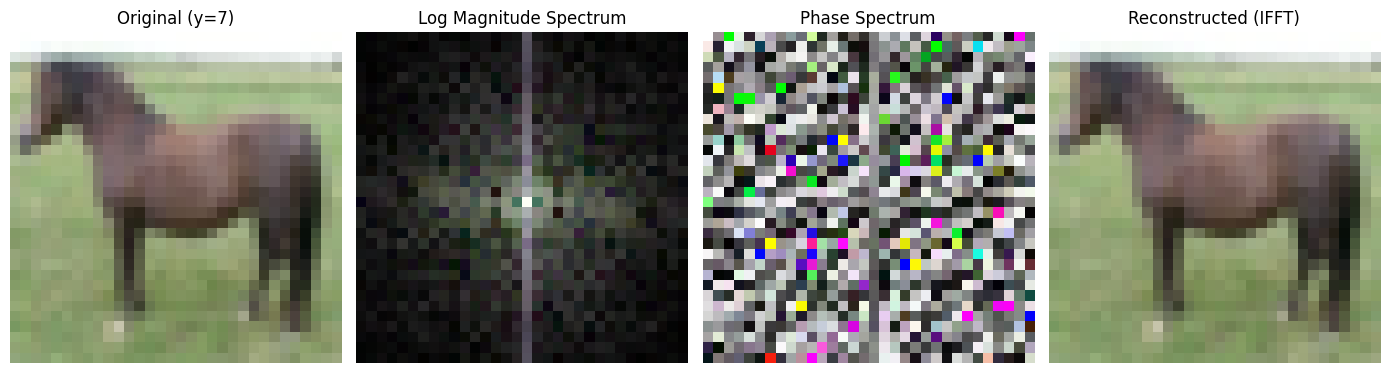

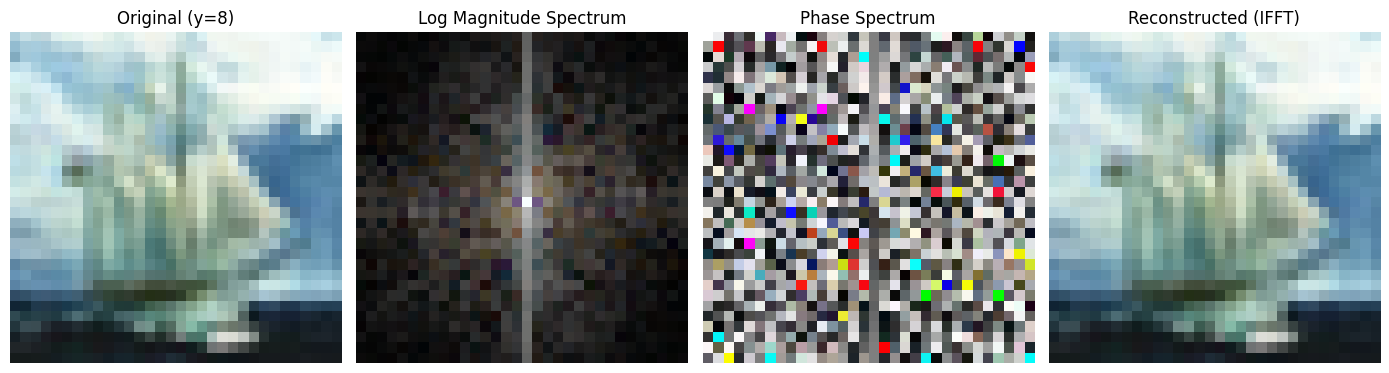

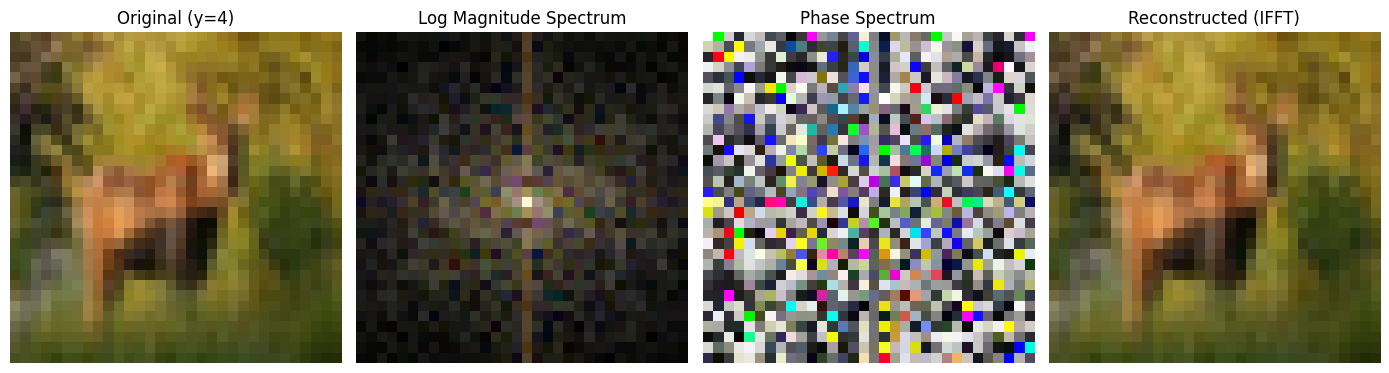

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset

transform = transforms.ToTensor()
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
subset = Subset(dataset, np.random.choice(len(dataset), 10_000, replace=False))

def get_item(i):
    return subset[i]  # (C,H,W), label

def fft2_centered(x):
    """Compute centered 2D FFT per channel."""
    X = torch.fft.fft2(x, dim=(-2, -1))
    return torch.fft.fftshift(X, dim=(-2, -1))

def ifft2_centered(X):
    """Inverse of fft2_centered."""
    x = torch.fft.ifftshift(X, dim=(-2, -1))
    x = torch.fft.ifft2(x, dim=(-2, -1))
    return x.real  # ignore small imaginary part

def magnitude_spectrum(X):
    """Log magnitude spectrum for visualization."""
    mag = torch.log1p(torch.abs(X))
    mag = mag / mag.max()
    return mag

def phase_spectrum(X):
    """Phase spectrum normalized to [0,1] for display."""
    phase = torch.angle(X)
    phase = (phase + np.pi) / (2 * np.pi)
    return phase

def chw_to_hwc(x):
    return x.detach().cpu().permute(1, 2, 0).numpy()

SAMPLE_INDICES = [0, 1, 2]

for i in SAMPLE_INDICES:
    x, y = get_item(i)  # (3,32,32), label

    # Forward and inverse FFT
    X = fft2_centered(x)
    x_recon = ifft2_centered(X).clamp(0, 1)

    # Visualization components
    mag = magnitude_spectrum(X)
    phase = phase_spectrum(X)

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))

    axes[0].imshow(chw_to_hwc(x))
    axes[0].set_title(f"Original (y={y})")
    axes[0].axis("off")

    axes[1].imshow(chw_to_hwc(mag), cmap="gray")
    axes[1].set_title("Log Magnitude Spectrum")
    axes[1].axis("off")

    axes[2].imshow(chw_to_hwc(phase), cmap="twilight")
    axes[2].set_title("Phase Spectrum")
    axes[2].axis("off")

    axes[3].imshow(chw_to_hwc(x_recon))
    axes[3].set_title("Reconstructed (IFFT)")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


# Evaluation

# Model Setup + Profiling CPU Runtimes

Training Wavelet model...
Epoch 1/10, Loss=2.1108
Epoch 2/10, Loss=1.8449
Epoch 3/10, Loss=1.7689
Epoch 4/10, Loss=1.7046
Epoch 5/10, Loss=1.6674
Epoch 6/10, Loss=1.6351
Epoch 7/10, Loss=1.6081
Epoch 8/10, Loss=1.5893
Epoch 9/10, Loss=1.5600
Epoch 10/10, Loss=1.5407
Wavelet model evaluation:
Accuracy: 44.40%

Training FFT model...
Epoch 1/10, Loss=2.2430
Epoch 2/10, Loss=2.0963
Epoch 3/10, Loss=2.0350
Epoch 4/10, Loss=2.0201
Epoch 5/10, Loss=2.0042
Epoch 6/10, Loss=1.9890
Epoch 7/10, Loss=1.9716
Epoch 8/10, Loss=1.9559
Epoch 9/10, Loss=1.9394
Epoch 10/10, Loss=1.9310
FFT model evaluation:
Accuracy: 30.45%

Wavelet Sub-band: LL
Epoch 1/5, Loss=2.1471
Epoch 2/5, Loss=1.9885
Epoch 3/5, Loss=1.9078
Epoch 4/5, Loss=1.8467
Epoch 5/5, Loss=1.8038
Accuracy: 34.50%

Wavelet Sub-band: LH
Epoch 1/5, Loss=2.2584
Epoch 2/5, Loss=2.1486
Epoch 3/5, Loss=2.0886
Epoch 4/5, Loss=2.0351
Epoch 5/5, Loss=1.9921
Accuracy: 27.75%

Wavelet Sub-band: HL
Epoch 1/5, Loss=2.2166
Epoch 2/5, Loss=2.0574
Epoch 3/5, 

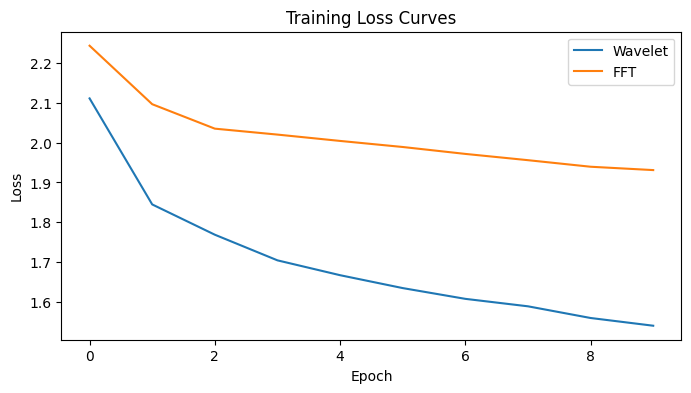

Profiling Wavelet model...
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        14.04%       3.192ms       100.00%      22.737ms      22.737ms             1  
                     aten::conv2d         0.81%     183.438us        44.49%      10.115ms       5.057ms             2  
                aten::convolution         0.43%      96.996us        43.68%       9.931ms       4.966ms             2  
               aten::_convolution         0.30%      69.060us        43.25%       9.834ms       4.917ms             2  
         aten::mkldnn_convolution        42.66%       9.699ms        42.95%       9.765ms       4.883ms             2  
             

/usr/local/lib/python3.12/dist-packages/torch/autograd/profiler.py:267: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity

s = 1.0 / np.sqrt(2.0)

def haar_dwt2(img):
    C,H,W = img.shape
    even_cols, odd_cols = img[:,:,::2], img[:,:,1::2]
    low_c = s*(even_cols + odd_cols)
    high_c = s*(even_cols - odd_cols)
    even_rows, odd_rows = low_c[:,::2,:], low_c[:,1::2,:]
    LL = s*(even_rows + odd_rows)
    HL = s*(even_rows - odd_rows)
    even_rows_h, odd_rows_h = high_c[:,::2,:], high_c[:,1::2,:]
    LH = s*(even_rows_h + odd_rows_h)
    HH = s*(even_rows_h - odd_rows_h)
    return LL, LH, HL, HH

def fft_features(img):
    X = torch.fft.fft2(img, dim=(-2,-1))
    X = torch.fft.fftshift(X, dim=(-2,-1))
    mag = torch.log1p(torch.abs(X))
    phase = torch.angle(X)
    return mag, phase

transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Use smaller subsets for fast experiments; can use full dataset
train_subset = Subset(train_dataset, np.random.choice(len(train_dataset), 10000, replace=False))
test_subset  = Subset(test_dataset, np.random.choice(len(test_dataset), 2000, replace=False))

class WaveletDataset(Dataset):
    def __init__(self, subset, use_subbands=[0,1,2,3]):
        self.subset = subset
        self.use_subbands = use_subbands  # LL,LH,HL,HH
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        LL,LH,HL,HH = haar_dwt2(x)
        subs = [LL,LH,HL,HH]
        feat = torch.cat([subs[i] for i in self.use_subbands], dim=0)
        return feat, y

class FFTDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        mag, phase = fft_features(x)
        feat = torch.cat([mag, phase], dim=0)
        return feat, y

class WaveletCNN(nn.Module):
    def __init__(self, n_classes=10, input_ch=12):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_ch, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64, n_classes)
    def forward(self, x):
        x = self.conv(x).flatten(1)
        return self.fc(x)

class FFTCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(6,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64, n_classes)
    def forward(self, x):
        x = self.conv(x).flatten(1)
        return self.fc(x)

def train_model(model, dataset, epochs=20, batch_size=64, lr=1e-3, device='cuda'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss={avg_loss:.4f}")
    return model, loss_history

def evaluate_model(model, dataset, batch_size=64, device='cuda'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f"Accuracy: {acc*100:.2f}%")
    return acc

def profile_model(model, dataset, batch_size=64, device='cuda'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model = model.to(device)
    x, _ = next(iter(loader))
    x = x.to(device)
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        with record_function("model_inference"):
            model(x)
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Wavelet full
wavelet_train = WaveletDataset(train_subset)
wavelet_test  = WaveletDataset(test_subset)
wavelet_model = WaveletCNN(input_ch=12)
print("Training Wavelet model...")
wavelet_model, wavelet_loss = train_model(wavelet_model, wavelet_train, epochs=10, device=device)
print("Wavelet model evaluation:")
wavelet_acc = evaluate_model(wavelet_model, wavelet_test, device=device)

# FFT
fft_train = FFTDataset(train_subset)
fft_test  = FFTDataset(test_subset)
fft_model = FFTCNN()
print("\nTraining FFT model...")
fft_model, fft_loss = train_model(fft_model, fft_train, epochs=10, device=device)
print("FFT model evaluation:")
fft_acc = evaluate_model(fft_model, fft_test, device=device)

# Sub-band Ablation (Wavelet)
subbands = { "LL":[0], "LH":[1], "HL":[2], "HH":[3], "ALL":[0,1,2,3] }
for name, bands in subbands.items():
    print(f"\nWavelet Sub-band: {name}")
    ds = WaveletDataset(train_subset, use_subbands=bands)
    model = WaveletCNN(input_ch=len(bands)*3)  # each band has 3 channels
    model, _ = train_model(model, ds, epochs=5, device=device) # ACTUAL EXPERIMENT USE 50 epochs, set to 5 for a quick run/check code works
    test_ds = WaveletDataset(test_subset, use_subbands=bands)
    evaluate_model(model, test_ds, device=device)

plt.figure(figsize=(8,4))
plt.plot(wavelet_loss,label="Wavelet")
plt.plot(fft_loss,label="FFT")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()

print("Profiling Wavelet model...")
profile_model(wavelet_model, wavelet_test, device=device)
print("Profiling FFT model...")
profile_model(fft_model, fft_test, device=device)


# FLOPs & GPU Run-Time Analysis With Accuracy + Sub-Band Analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=e01f9e5cab65b2766f89cdc2e2b76eed59507491739325f84ee217097db0d0ba
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=d85e23523f6cbbd45f71215d43f26a11d3aae80f62eccf5bc5ab277e9c79c207
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


Epoch 1/5, Loss=2.1568
Epoch 2/5, Loss=1.9858
Epoch 3/5, Loss=1.8730
Epoch 4/5, Loss=1.7962
Epoch 5/5, Loss=1.7490


Epoch 1/5, Loss=2.2674
Epoch 2/5, Loss=2.1737
Epoch 3/5, Loss=2.1314
Epoch 4/5, Loss=2.0728
Epoch 5/5, Loss=2.0053


Epoch 1/5, Loss=2.2085
Epoch 2/5, Loss=2.0530
Epoch 3/5, Loss=2.0026
Epoch 4/5, Loss=1.9400
Epoch 5/5, Loss=1.8810


Epoch 1/5, Loss=2.2973
Epoch 2/5, Loss=2.2344
Epoch 3/5, Loss=2.1955
Epoch 4/5, Loss=2.1733
Epoch 5/5, Loss=2.1505


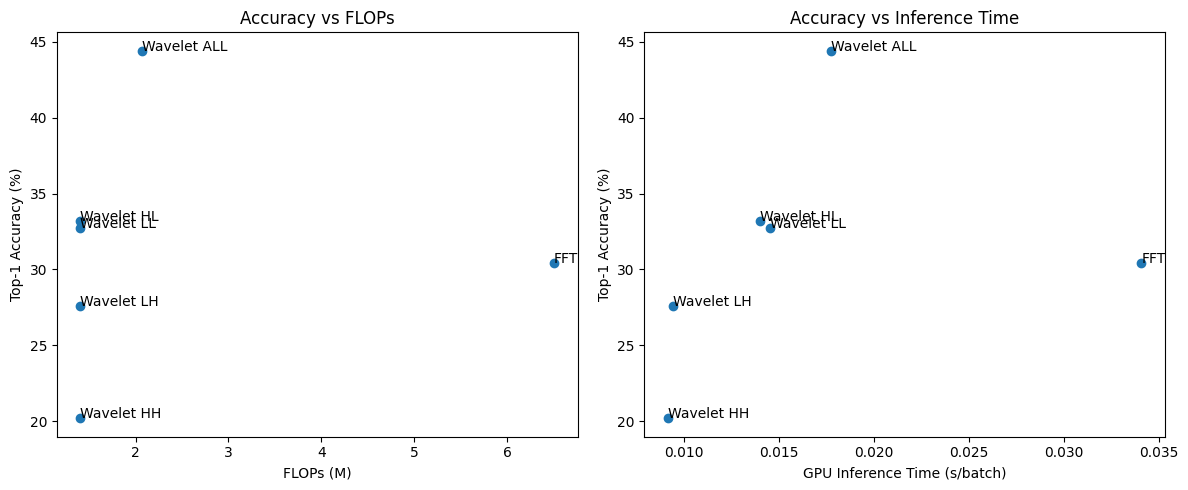

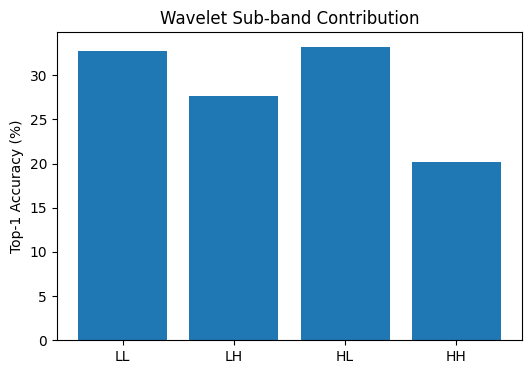


Summary Table:
Wavelet ALL     | Acc: 44.40% | Time: 0.0178s | FLOPs: 2.1e+06
FFT             | Acc: 30.45% | Time: 0.0341s | FLOPs: 6.5e+06
Wavelet LL      | Acc: 32.75% | Time: 0.0145s | FLOPs: 1.4e+06
Wavelet LH      | Acc: 27.60% | Time: 0.0094s | FLOPs: 1.4e+06
Wavelet HL      | Acc: 33.20% | Time: 0.0140s | FLOPs: 1.4e+06
Wavelet HH      | Acc: 20.20% | Time: 0.0092s | FLOPs: 1.4e+06


In [ ]:
!pip install fvcore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt
import time

def compute_flops(model, dataset, batch_size=1, device='cuda'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model = model.to(device)
    x, _ = next(iter(loader))
    x = x.to(device)
    flops = FlopCountAnalysis(model, x)
    return flops.total()

def measure_inference_time(model, dataset, batch_size=64, device='cuda'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval().to(device)
    x, _ = next(iter(loader))
    x = x.to(device)
    torch.cuda.synchronize() if device=='cuda' else None
    start = time.time()
    _ = model(x)
    torch.cuda.synchronize() if device=='cuda' else None
    elapsed = time.time() - start
    return elapsed

def evaluate_model(model, dataset, batch_size=64, device='cuda'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval().to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    acc = correct / total
    return acc*100

results = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Wavelet ALL
wavelet_test = WaveletDataset(test_subset, use_subbands=[0,1,2,3])
wavelet_model.eval()
wavelet_acc = evaluate_model(wavelet_model, wavelet_test, device=device)
wavelet_time = measure_inference_time(wavelet_model, wavelet_test, device=device)
wavelet_flops = compute_flops(wavelet_model, wavelet_test, device=device)
results.append({
    "model":"Wavelet ALL",
    "accuracy": wavelet_acc,
    "time": wavelet_time,
    "flops": wavelet_flops
})

# FFT
fft_test = FFTDataset(test_subset)
fft_model.eval()
fft_acc = evaluate_model(fft_model, fft_test, device=device)
fft_time = measure_inference_time(fft_model, fft_test, device=device)
fft_flops = compute_flops(fft_model, fft_test, device=device)
results.append({
    "model":"FFT",
    "accuracy": fft_acc,
    "time": fft_time,
    "flops": fft_flops
})

# Wavelet sub-bands
subbands = { "LL":[0], "LH":[1], "HL":[2], "HH":[3] }
for name, bands in subbands.items():
    ds = WaveletDataset(train_subset, use_subbands=bands)
    test_ds = WaveletDataset(test_subset, use_subbands=bands)
    model = WaveletCNN(input_ch=len(bands)*3)
    model, _ = train_model(model, ds, epochs=5, device=device) # change
    acc = evaluate_model(model, test_ds, device=device)
    t = measure_inference_time(model, test_ds, device=device)
    f = compute_flops(model, test_ds, device=device)
    results.append({
        "model": f"Wavelet {name}",
        "accuracy": acc,
        "time": t,
        "flops": f
    })

# Accuracy vs FLOPs
names = [r["model"] for r in results]
accs  = [r["accuracy"] for r in results]
flops = [r["flops"]/1e6 for r in results]  # convert to MFLOPs
times = [r["time"] for r in results]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(flops, accs)
for i, txt in enumerate(names):
    plt.annotate(txt, (flops[i], accs[i]))
plt.xlabel("FLOPs (M)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Accuracy vs FLOPs")

# Accuracy vs Inference Time
plt.subplot(1,2,2)
plt.scatter(times, accs)
for i, txt in enumerate(names):
    plt.annotate(txt, (times[i], accs[i]))
plt.xlabel("GPU Inference Time (s/batch)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Accuracy vs Inference Time")
plt.tight_layout()
plt.show()

# Sub-band contribution curves
subband_accs = [r["accuracy"] for r in results if "Wavelet" in r["model"] and r["model"]!="Wavelet ALL"]
subband_names = [r["model"].split()[-1] for r in results if "Wavelet" in r["model"] and r["model"]!="Wavelet ALL"]

plt.figure(figsize=(6,4))
plt.bar(subband_names, subband_accs)
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Wavelet Sub-band Contribution")
plt.show()

print("\nSummary Table:")
for r in results:
    print(f"{r['model']:15s} | Acc: {r['accuracy']:.2f}% | Time: {r['time']:.4f}s | FLOPs: {r['flops']:.1e}")


# Classwise Accuracy Analysis & Dimensionality Reducation Visualization of Learned Features of Wavelet Driven Model

Wavelet Model Top-1/Top-3: [44.4, 77.6]
FFT Model Top-1/Top-3: [30.45, 64.05]


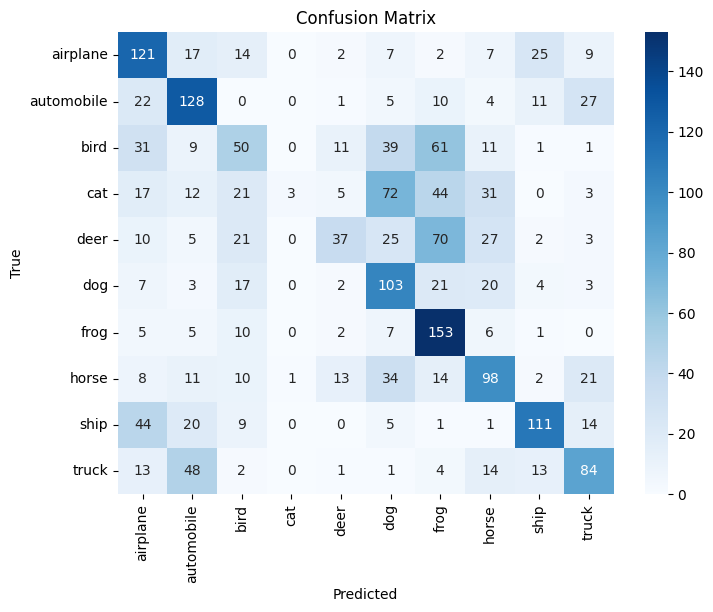

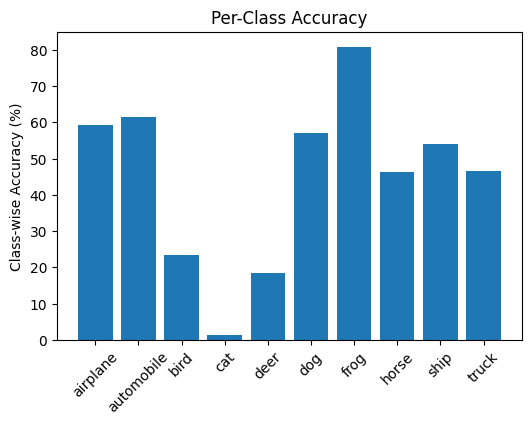

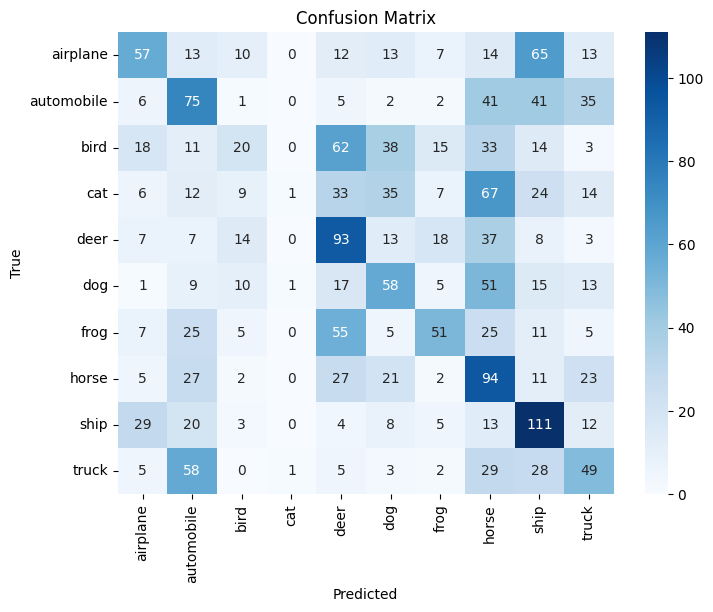

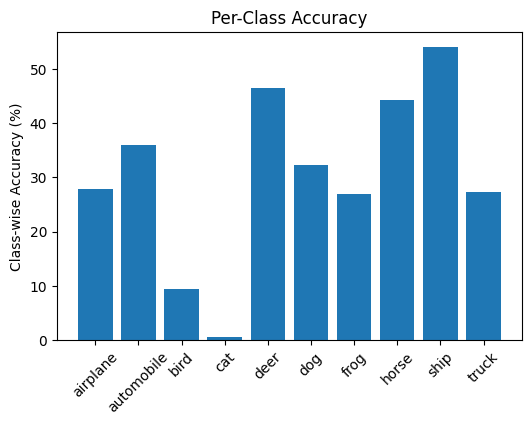

Wavelet: FLOPs=2.07M, Params=0.02M, PeakMem=N/AMB, Time=0.0009s
FFT:     FLOPs=6.51M, Params=0.02M, PeakMem=N/AMB, Time=0.0022s
Epoch 1/5, Loss=2.1378
Epoch 2/5, Loss=1.9573
Epoch 3/5, Loss=1.8831
Epoch 4/5, Loss=1.8314
Epoch 5/5, Loss=1.7862
Epoch 1/5, Loss=2.2674
Epoch 2/5, Loss=2.1742
Epoch 3/5, Loss=2.1270
Epoch 4/5, Loss=2.0700
Epoch 5/5, Loss=2.0147
Epoch 1/5, Loss=2.1866
Epoch 2/5, Loss=2.0490
Epoch 3/5, Loss=1.9963
Epoch 4/5, Loss=1.9413
Epoch 5/5, Loss=1.8989
Epoch 1/5, Loss=2.2930
Epoch 2/5, Loss=2.2283
Epoch 3/5, Loss=2.1935
Epoch 4/5, Loss=2.1722
Epoch 5/5, Loss=2.1511
Epoch 1/5, Loss=2.1032
Epoch 2/5, Loss=1.8525
Epoch 3/5, Loss=1.7643
Epoch 4/5, Loss=1.7281
Epoch 5/5, Loss=1.6822


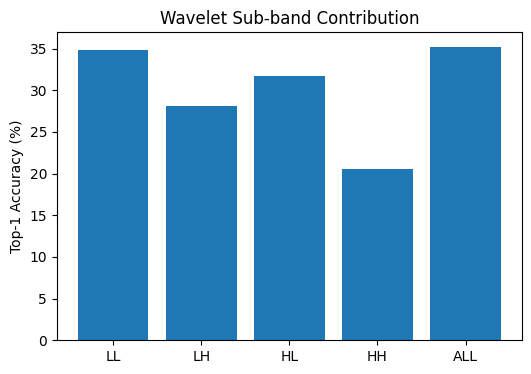

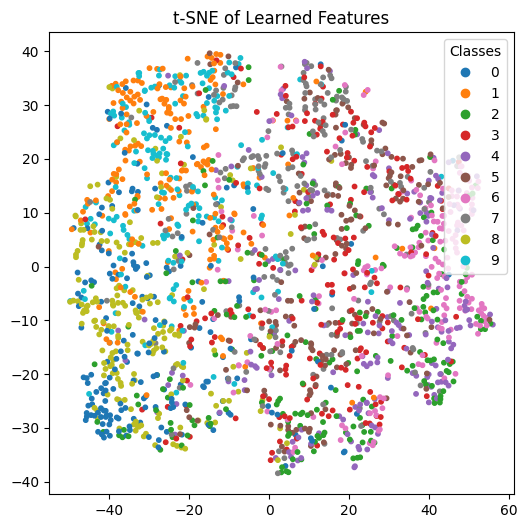

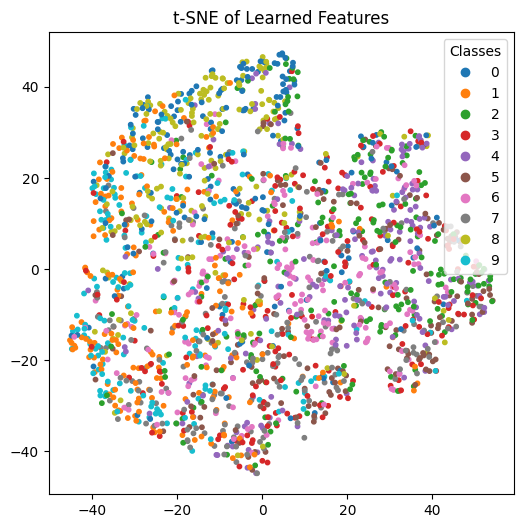

(array([[ -1.1419191, -40.209606 ],
        [-16.198393 , -27.561563 ],
        [-12.530241 ,  26.630346 ],
        ...,
        [ 18.310286 ,  -3.7345037],
        [ 32.386917 , -21.961267 ],
        [-24.728815 , -30.716301 ]], dtype=float32),
 array([4, 5, 1, ..., 4, 7, 9]))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import time
from fvcore.nn import FlopCountAnalysis

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Top-k Accuracy
def topk_accuracy(model, dataset, topk=(1,3), batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval().to(device)
    correct_topk = [0]*len(topk)
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            total += y.size(0)
            for i,k in enumerate(topk):
                pred = out.topk(k, dim=1)[1]
                correct_topk[i] += (pred==y.unsqueeze(1)).sum().item()
    accs = [100*c/total for c in correct_topk]
    return accs

wavelet_topk = topk_accuracy(wavelet_model, wavelet_test)
fft_topk     = topk_accuracy(fft_model, fft_test)
print(f"Wavelet Model Top-1/Top-3: {wavelet_topk}")
print(f"FFT Model Top-1/Top-3: {fft_topk}")

# Confusion Matrix & Class-wise Accuracy
def plot_confusion(model, dataset, class_names):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval().to(device)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            y_true.append(y.cpu())
            y_pred.append(pred.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    cm = confusion_matrix(y_true, y_pred)
    acc_per_class = cm.diagonal()/cm.sum(axis=1)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.bar(class_names, acc_per_class*100)
    plt.ylabel("Class-wise Accuracy (%)")
    plt.title("Per-Class Accuracy")
    plt.xticks(rotation=45)
    plt.show()
    return acc_per_class*100

class_names = train_dataset.classes
wavelet_class_acc = plot_confusion(wavelet_model, wavelet_test, class_names)
fft_class_acc     = plot_confusion(fft_model, fft_test, class_names)

# FLOPs, Parameters, GPU Memory, Inference Time
def profile_model(model, dataset, batch_size=1):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model = model.to(device)
    x, _ = next(iter(loader))
    x = x.to(device)

    # FLOPs
    flops = FlopCountAnalysis(model, x).total()
    # Params
    params = sum(p.numel() for p in model.parameters())
    # Peak GPU memory
    torch.cuda.reset_peak_memory_stats() if device=='cuda' else None
    _ = model(x)
    peak_mem = torch.cuda.max_memory_allocated() if device=='cuda' else None
    # Inference time
    torch.cuda.synchronize() if device=='cuda' else None
    start = time.time()
    _ = model(x)
    torch.cuda.synchronize() if device=='cuda' else None
    inf_time = time.time() - start
    return flops, params, peak_mem, inf_time

wavelet_flops, wavelet_params, wavelet_mem, wavelet_time = profile_model(wavelet_model, wavelet_test)
fft_flops, fft_params, fft_mem, fft_time = profile_model(fft_model, fft_test)

print(f"Wavelet: FLOPs={wavelet_flops/1e6:.2f}M, Params={wavelet_params/1e6:.2f}M, PeakMem={wavelet_mem/1e6 if wavelet_mem else 'N/A'}MB, Time={wavelet_time:.4f}s")
print(f"FFT:     FLOPs={fft_flops/1e6:.2f}M, Params={fft_params/1e6:.2f}M, PeakMem={fft_mem/1e6 if fft_mem else 'N/A'}MB, Time={fft_time:.4f}s")

# Wavelet Sub-band Contribution
subbands = { "LL":[0], "LH":[1], "HL":[2], "HH":[3], "ALL":[0,1,2,3] }
subband_accs = {}
for name, bands in subbands.items():
    ds_train = WaveletDataset(train_subset, use_subbands=bands)
    ds_test  = WaveletDataset(test_subset, use_subbands=bands)
    model = WaveletCNN(input_ch=len(bands)*3).to(device)
    model, _ = train_model(model, ds_train, epochs=5, device=device)
    acc = topk_accuracy(model, ds_test)
    subband_accs[name] = acc if isinstance(acc,list) else [acc]

# Plot Sub-band Contribution
plt.figure(figsize=(6,4))
plt.bar(subband_accs.keys(), [v[0] for v in subband_accs.values()])
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Wavelet Sub-band Contribution")
plt.show()

# t-SNE Embeddings
def plot_tsne(model, dataset, perplexity=30):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval().to(device)
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            feat = model.conv(x).flatten(1)
            feats.append(feat.cpu())
            labels.append(y)
    feats = torch.cat(feats).numpy()
    labels = torch.cat(labels).numpy()
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    emb = tsne.fit_transform(feats)
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(emb[:,0], emb[:,1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("t-SNE of Learned Features")
    plt.show()
    return emb, labels

plot_tsne(wavelet_model, wavelet_test)
plot_tsne(fft_model, fft_test)
